In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

#import tokenization
!pip install bert-for-tf2
from bert import bert_tokenization

In [2]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [3]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [4]:
!pip install tensorflow-hub

In [5]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [6]:
trainset = pd.read_csv("train.csv")
testset = pd.read_csv("test.csv")

In [7]:
trainset.value_counts('target')

target
0    4342
1    3271
dtype: int64

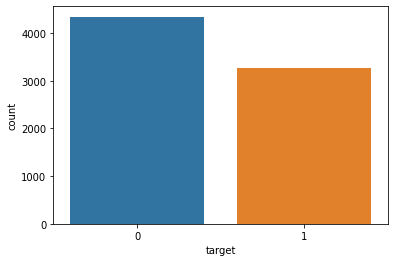

In [8]:
ax = sns.countplot(x="target", data=trainset)

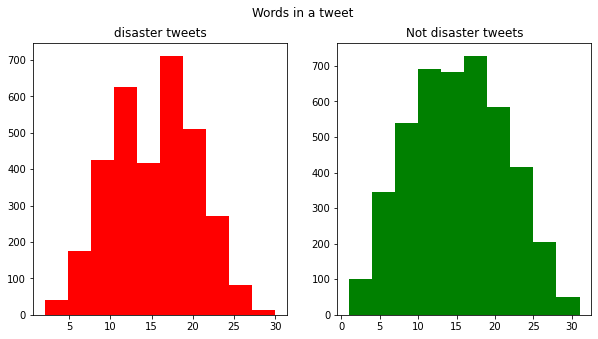

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=trainset[trainset['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=trainset[trainset['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [10]:
trainset.value_counts('location')

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Length: 3341, dtype: int64

In [11]:
#unique locations
print(trainset.location.nunique())

3341


In [12]:
print(testset.location.nunique())

1602


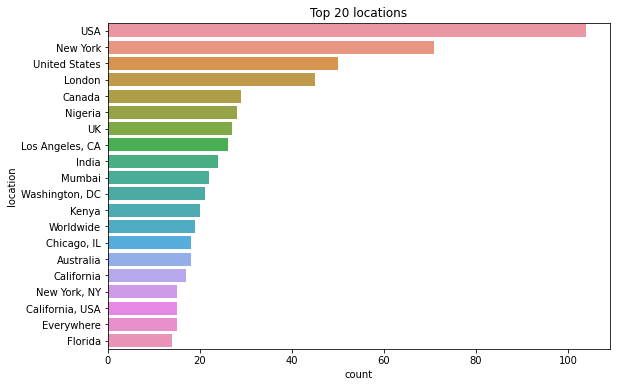

In [13]:
# Most common locations appearing in the tweets in the train set
plt.figure(figsize=(9,6))
sns.countplot(y=trainset.location, order = trainset.location.value_counts().iloc[:20].index)
plt.title('Top 20 locations')
plt.show()

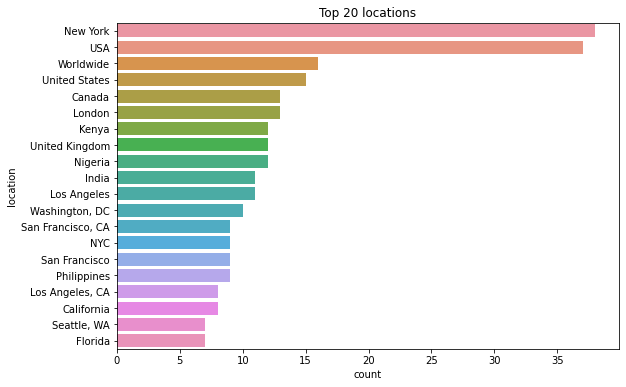

In [14]:
# Most common locations appearing in the tweets in the test set
plt.figure(figsize=(9,6))
sns.countplot(y=testset.location, order = testset.location.value_counts().iloc[:20].index)
plt.title('Top 20 locations')
plt.show()

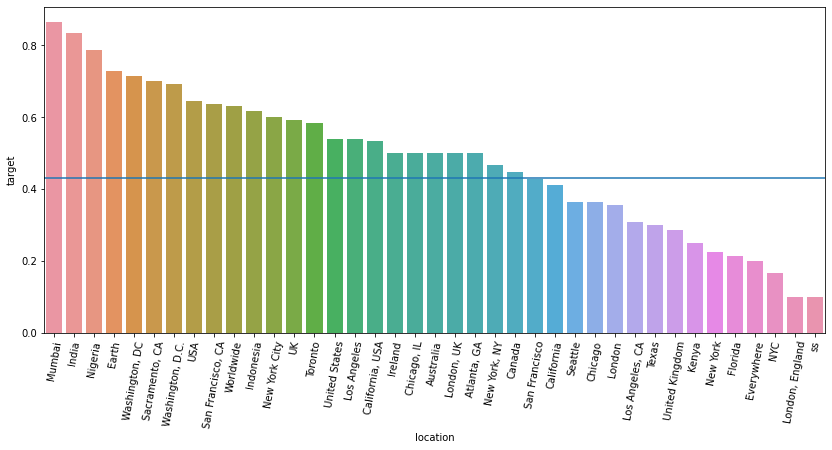

In [15]:
# % of disaster tweets for the common locations
raw_loc = trainset.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = trainset[trainset.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(trainset.target))
plt.xticks(rotation=80)
plt.show()

In [16]:
trainset.value_counts('keyword')

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Length: 221, dtype: int64

In [17]:
testset.value_counts('keyword')

keyword
deluged               23
rubble                22
demolished            22
first%20responders    21
obliteration          21
                      ..
forest%20fire          5
threat                 5
fatalities             5
inundation             4
epicentre              1
Length: 221, dtype: int64

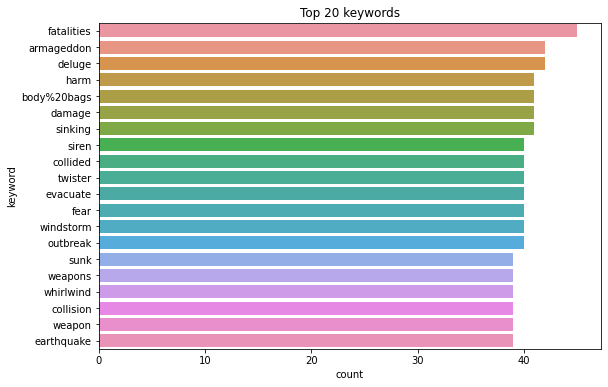

In [18]:
# Most common keywords appearing in the tweets in the train set
plt.figure(figsize=(9,6))
sns.countplot(y=trainset.keyword, order = trainset.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

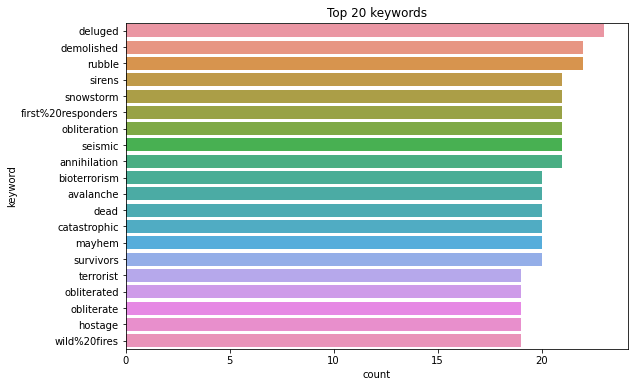

In [19]:
# Most common keywords appearing in the tweets in the test set
plt.figure(figsize=(9,6))
sns.countplot(y=testset.keyword, order = testset.keyword.value_counts().iloc[:20].index)
plt.title('Top 20 keywords')
plt.show()

In [20]:
trainset.drop(['id','location','keyword'], axis = 1,inplace=True)
testset.drop(['id','location','keyword'], axis = 1,inplace=True)

In [21]:
!pip install transformers

In [22]:
 from transformers import BertModel, BertTokenizer

In [23]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [24]:
!pip3 install sentencepiece
!pip3 install tf_sentencepiece

In [25]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tokenization


In [26]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [31]:
train_input = bert_encode(trainset.text.values, tokenizer, max_len=150)
test_input = bert_encode(testset.text.values, tokenizer, max_len=150)
train_labels = trainset.target.values

In [32]:
model = build_model(bert_layer, max_len=150)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=2,
    callbacks=[checkpoint],
    batch_size=16
)

Epoch 1/2


In [ ]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [ ]:
result_data = pd.read_csv("sample_submission.csv")
output = pd.DataFrame({'id': result_data.id, 'target': test_pred})
output.to_csv('my_submission.csv', index=False)